## DIPLOMATURA EN CIENCIA DE DATOS, APRENDIZAJE AUTOMÁTICO Y SUS APLICACIONES COHORTE 2022
### Materia optativa
# Aprendizaje Automático Profundo (Deep Learning)

- Fernanda Borghello,<br>
- Rodrigo Ruiz,<br>
- Alfonsina Szpeiner

## Modelo MLP
En este práctico trabajaremos en el problema de clasificación de texto del MeLi Challenge 2019.

**Ejercicio:**
Implementar una red neuronal que asigne una categoría dado un título. Para este práctico se puede usar cualquier tipo de red neuronal. 
1. Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2. Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3. Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4. Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5. Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6. Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy.

Adicionalmente, se pide un reporte de los experimentos y los procesos que se llevaron a cabo (en el README.md de su repositorio correspondiente). No se evaluará la performance de los modelos, sino el proceso de tomar el problema e implementar una solución con aprendizaje profundo.

# Librerías

In [1]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import bz2

import spacy
from spacy.lang.es.examples import sentences

from gensim import corpora
from gensim.parsing import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score, recall_score
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange
from datetime import datetime as dt

import gc

nltk.download("stopwords")

tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lectura de los datos

Los datos para el problema se dividen en tres conjuntos: train, validation y test. A los fines prácticos de poder realizar el ajuste de hiperparámetros en un lapso de tiempo acorde a la disponibilidad de los recursos de cálculo disponibles, se programó la opción de tomar una muestra aleatoria del 10% de los conjuntos train y validation; siempre procurando mantener la distribución de clases del conjunto original.

In [2]:
for i in trange(3):
    df_train = pd.read_json(f"./data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True)
    df_validation = pd.read_json(f"./data/meli-challenge-2019/spanish.validation.jsonl.gz", lines=True)
    df_test = pd.read_json(f"./data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)

len(df_train), len(df_validation), len(df_test)

  0%|          | 0/3 [00:00<?, ?it/s]

(4895280, 1223820, 63680)

In [3]:
use_sampler = True
if use_sampler:
    df_train = shuffle(df_train, random_state=0)
    data_train, df = train_test_split(df_train, train_size = 0.10, random_state = 0, stratify = df_train.category)
    df_validation = shuffle(df_validation, random_state=0)
    data_validation, df =  train_test_split(df_validation, train_size = 0.10, random_state = 0, stratify = df_validation.category)
    data_train_val = pd.concat([data_train, data_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size, test_size = len(data_train), len(data_validation), len(df_test)
    print(f'Train: {train_size} - Validation: {validation_size} - Test: {test_size}')
else:    
    data_train_val = pd.concat([df_train, df_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size, test_size = len(df_train), len(df_validation), len(df_test)
    print(f'Train: {train_size} - Validation: {validation_size} - Test: {test_size}')

Train: 489528 - Validation: 122382 - Test: 63680


Se grafican las 10 categorías con mayor frecuencia y las 10 con menor frecuencia, para cada uno de los conjuntos de datos.

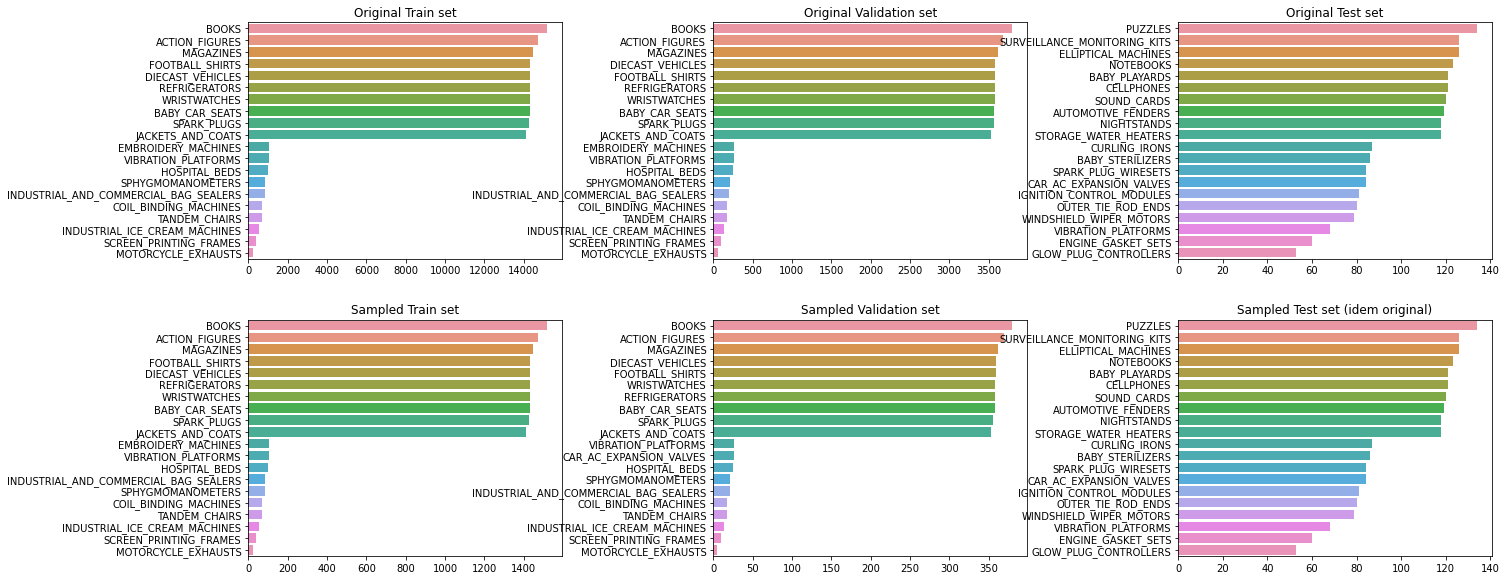

In [4]:
cat_size_train_org = pd.concat([df_train['category'].value_counts()[:10], df_train['category'].value_counts()[-10:]], axis=0)
cat_size_val_org = pd.concat([df_validation['category'].value_counts()[:10], df_validation['category'].value_counts()[-10:]], axis=0)

cat_size_train = pd.concat([data_train['category'].value_counts()[:10], data_train['category'].value_counts()[-10:]], axis=0)
cat_size_val = pd.concat([data_validation['category'].value_counts()[:10], data_validation['category'].value_counts()[-10:]], axis=0)
cat_size_test = pd.concat([df_test['category'].value_counts()[:10], df_test['category'].value_counts()[-10:]], axis=0)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,8), sharey=False)
fig.tight_layout(h_pad=4, w_pad=12)
sns.barplot(y=cat_size_train_org.index, x=cat_size_train_org.values, ax=ax[0,0])
ax[0,0].set_title('Original Train set')
sns.barplot(y=cat_size_val_org.index, x=cat_size_val_org.values, ax=ax[0,1])
ax[0,1].set_title('Original Validation set')
sns.barplot(y=cat_size_test.index, x=cat_size_test.values, ax=ax[0,2])
ax[0,2].set_title('Original Test set')
sns.barplot(y=cat_size_train.index, x=cat_size_train.values, ax=ax[1,0])
ax[1,0].set_title('Sampled Train set')
sns.barplot(y=cat_size_val.index, x=cat_size_val.values, ax=ax[1,1])
ax[1,1].set_title('Sampled Validation set')
sns.barplot(y=cat_size_test.index, x=cat_size_test.values, ax=ax[1,2])
ax[1,2].set_title('Sampled Test set (idem original)');

In [5]:
print(f'Train unique categories: {data_train.category.nunique()}\n\
Validation unique categories: {data_validation.category.nunique()}\n\
Test unique categories: {df_test.category.nunique()}')


Train unique categories: 632
Validation unique categories: 632
Test unique categories: 632


Como puede observarse, las muestras seleccionadas mantienen la distribución de los conjuntos originales; y se asegura que dentro de cada conjunto estén las 632 categorías. Es importante también resaltar que los 3 conjuntos están muy desbalanceados.
Luego, el entrenamiento del modelo seleccionado como definitivo será realizado con todos los datos del conjunto train y se analizará el desempeño sobre todo el conjunto test.

In [6]:
# liberamos memoria
del df
del df_train
del df_validation
del df_test # después lo cargamos de nuevo al momento de probar el modelo final

# Datasets

Se crearon dos clases dataset, una para levantar todos los datos del lote y otra que lo hace en forma iterable, según las posibilidades de cómputo.

In [16]:
class MeLiChallengeDataset(Dataset):
    def __init__(self, path, transform=None):
#         self.dataset = pd.read_json(path, lines=True)
        self.dataset = path
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()  # Deal with list of items instead of tensor
        
        item = {
            'data': self.dataset.iloc[item]['title'],
            'target': self.dataset.iloc[item]['category']
        }

        if self.transform:
            item = self.transform(item)
        
        return item

In [17]:
class MeLiChallengeiterDataset(IterableDataset):
    def __init__(self, path, transform=None):
        self.dataset_path = path
        self.transform = transform

    def __iter__(self):
        with gzip.open(self.dataset_path, "rt") as fh:
            for l in fh:
                data = json.loads(l)
                item = {
                    "data": data['title'],
                    "target": data['category']
                }
                
                if self.transform:
                    yield self.transform(item)
                else:
                    yield item

# Preprocesamiento

El preprocesamiento de los títulos se realizó utilizando las librerías Gensim y NLTK. Las tareas se ejecutan en el siguiente orden:
- Transformar todas las cadenas en minúsculas
- Eliminar etiquetas de código del tipo <i></i>, <b></b>
- Separar por un espacio de cadenas alfanuméricas
- Reemplazar signos de puntuación ASCII por espacios
- Eliminar cualquier otro caracter que no sea letras o númemros
- Remover espacios múltiples
- Eliminar dígitos numéricos
- Descartar las cadenas de longitud menor a 3

Una vez generado el diccionario de palabras, se eliminan de este las palabras vacías (o stopwords) del listado predefinido para español en la librería NLTK. Esto es para propiciar que en diccionario aparezcan palabras que puedan aportar información relevante.
Luego, se incluyen dos tokens especiales. Uno para las palabras desconocidas (1) y otro para el relleno al ajustar el tamaño de las cadenas (0).
Por último, se codifican las categorías con un índice, por orden de aparición. En este caso se cuenta con 632 categrías diferentes.

In [18]:
es_stopwords = stopwords.words("spanish")

In [19]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags, #Remove tags using RE_TAGS.
                preprocessing.split_alphanum, #Add spaces between digits & letters using RE_AL_NUM. AGREGADO
                preprocessing.strip_punctuation, #Replace ASCII punctuation characters with spaces using RE_PUNCT.
                preprocessing.strip_non_alphanum, #Remove non-alphabetic characters using RE_NONALPHA.
                preprocessing.strip_multiple_whitespaces, # Remove repeating whitespace characters
                preprocessing.strip_numeric, #Remove digits using RE_NUMERIC.
                preprocessing.strip_short, #Remove words with length lesser than minsize (default = 3).
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )

        # Remove stopwords from dictionary
        stopword_ids = map(self.dictionary.token2id.get, es_stopwords)
        self.dictionary.filter_tokens(bad_ids=stopword_ids)
              
        # Filter the dictionary with extremos words
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
                
        # Make the indices continuous after some words have been removed
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}

    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _remove_stopwords(self, wdlist):
        # incorporamos una funcion para extraer las stopwords en espanol
        return [word for word in wdlist if word not in es_stopwords]
    
    def _sentence_to_indices(self, sentence):
        # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._remove_stopwords(self._preprocess_string(data)))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }


In [20]:
preprocess = RawDataProcessor(data_train_val)

In [21]:
print(f'Tamaño del diccionario: {len(preprocess.dictionary)}')

Tamaño del diccionario: 50002


In [22]:
use_iterableDataset = False

if use_iterableDataset:
    train_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.train.jsonl.gz", transform=preprocess)
    val_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.validation.jsonl.gz", transform=preprocess)
else:
    train_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'train'], transform=preprocess)
    val_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'validation'], transform=preprocess)

# PadSequences

Se creó una clase PadSequences para iguales el tamaño de los datos con los que será alimentada la red.

In [23]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

# DataLoaders

Además, se utilizaron los dataloaders de Pytorch para pasar los datos por lotes a la red.

In [14]:
pad_sequences = PadSequences()
batch_size = 128

if use_iterableDataset:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=pad_sequences, drop_last=False)

# Modelo baseline

Se diseñó un modelo simple con una capa de emeding, luego una capa oculta con función de activación relu y la capa de salida. La función de pérdida utilizada para todo el trabajo fue CrossEntropyLoss, apropiada para problemas de clasificación muticlase. Además, se optó por utiilizar Adam como algoritmo de optimización. Por una cuestión de capacidad de procesamiento todos los modelos fueron entrenados en 5 épocas. Se intentó con 10 épocas para poder tener un rango más amplio y evaluar si la función de pérdida podía mostrar signos de sobreajuste; pero esto no fue posible porque en el 90% de los casos el proceso no puede concluir por falta de recursos, se detenía el kernel. La métrica utilizada para evaluar los modelos fue balanced accuracy.

In [15]:
class MLPBaseTitleClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, 256)
        self.output_layer = nn.Linear(256, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden_layer1(x))
        x = self.output_layer(x) # use of CrossEntropyLoss() equivalent to the combination of LogSoftmax and NLLLoss.
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
EPOCHS = 5
BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

model = MLPBaseTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess.dictionary,
                        vector_size=300,
                        freeze_embedings=True)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in trange(EPOCHS):
    model.to(device)
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, total=BATCHES_t)
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_value = loss_function(output, target)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
            pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
            running_loss = 0.0

    model.eval()
    targets = []
    predictions = []
    running_loss = 0
    pbar = tqdm(val_loader, total=BATCHES_v)
    with torch.no_grad():
        for idx, batch in enumerate(pbar):
            # get the input
            data = batch["data"].to(device)
            target = batch["target"].to(device)  
            output = model(data)
            loss_value = loss_function(output, target)
            targets.extend(target.cpu().numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            running_loss += loss_value.item()
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        metric = balanced_accuracy_score(targets, predictions)

    print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6144084102215718


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6480728511654785


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6652756297541426


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6727197388600352


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6742794280615031


El modelo baseline alcanzó un resultado de 67.4%, y será la línea base para comprar con otras arquitecturas de red e hiperparámetros.

# Modelo para ajustar hiperparámetros

Para la búsqueda de los mejores hiperparámetro se agregó una capa oculta adicional y dropout a la red. Además, se definió una función para el entrenamiento y evaluación de los modelos que recibe como parámetros el tamaño de la primera y segunda capa oculta, la propoción para el dropout, la función de activación, el algoritmo de optimización, tasa de aprendizaje, parámetro de regularización, épocas y la opción de guardar los parámetros del modelo entrenado.

In [24]:
class MLPTitleClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 activation_fn,
                 neurons_h1,
                 neurons_h2,
                 p_dropout):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, neurons_h1)
        self.hidden_layer1_dp = nn.Dropout(p=p_dropout)
        self.hidden_layer2 = nn.Linear(neurons_h1, neurons_h2)
        self.hidden_layer2_dp = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(neurons_h2, 632)
        self.vector_size = vector_size
        self.activation_fn = activation_fn
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = self.activation_fn(self.hidden_layer1(x))
        if self.training:
            x = self.hidden_layer1_dp(x)
        x = self.activation_fn(self.hidden_layer2(x))
        if self.training:
            x = self.hidden_layer2_dp(x)
        x = self.output_layer(x) # use of CrossEntropyLoss() equivalent to the combination of LogSoftmax and NLLLoss.
        return x

## Experimentos registrados con MLflow

Todos los experimentos fueron registrados con MLflow para poder comprar los modelos y optener las gráficas de pérdida para entrenamiento y evaluación.

In [17]:
def train_eval(neurons_h1, neurons_h2, p_dropout, activation_fn, opt, lr, wd, epochs, save_model):
    EPOCHS = epochs
    BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
    BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

    mlflow.set_experiment("exp_nn_mlp")

    with mlflow.start_run():
        model = MLPTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                                dictionary=preprocess.dictionary,
                                vector_size=300,
                                freeze_embedings=True,
                                activation_fn=activation_fn,
                                neurons_h1=neurons_h1,
                                neurons_h2=neurons_h2,
                                p_dropout=p_dropout)

        loss_function = nn.CrossEntropyLoss()
        optimizer = opt(model.parameters(), lr=lr, weight_decay=wd)

        mlflow.log_params({
            "model_name": "mlp",
            "model": model,
            "freeze_embedding": True,
            "embedding_size": 300,
            "neurons_hlayer1": neurons_h1,
            "neurons_hlayer2": neurons_h2,
            "Dropout": p_dropout,
            "activation_function": activation_fn,
            "optimizer": optimizer,            
            "learning_rate": lr,
            "weight_decay": wd,
        })

        for epoch in trange(EPOCHS):
            model.to(device)
            model.train()
            running_loss = 0.0
            running_loss_flow = []
            pbar = tqdm(train_loader, total=BATCHES_t)
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)
                optimizer.zero_grad()
                output = model(data)
                loss_value = loss_function(output, target)
                loss_value.backward()
                optimizer.step()
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)

            model.eval()
            targets = []
            predictions = []
            running_loss = 0
            running_loss_flow = []
            pbar = tqdm(val_loader, total=BATCHES_v)
            with torch.no_grad():
                for idx, batch in enumerate(pbar):
                    data = batch["data"].to(device)
                    target = batch["target"].to(device)  
                    output = model(data)
                    loss_value = loss_function(output, target)
                    targets.extend(target.cpu().numpy())
                    predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
                    running_loss += loss_value.item()
                    running_loss_flow.append(loss_value.item())
                    if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                        pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                        running_loss = 0.0
                mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
                metric = balanced_accuracy_score(targets, predictions)
                mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

            print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

        ahora = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
        nombre_archivo = 'predictions_' + ahora + '.csv.gz'
        with tempfile.TemporaryDirectory() as tmpdirname:
            targets = []
            predictions = []
            for batch in pbar:
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                targets.extend(target.cpu().numpy())
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
                f"{tmpdirname}/{nombre_archivo}", index=False
            )
            mlflow.log_artifact(f"{tmpdirname}/{nombre_archivo}")
    if save_model:
        # se guarda el modelo entrenado
        path_archivo = './data/MLPTitleClassifier_' + ahora + '.pth'
        torch.save(model.state_dict(), path_archivo)

## Búsqueda mejor combinación de hiperparámetros

Dada la elección de posibles hiperparámetros, había que evaluar 64 modelos. Para evitar el riesgo de perder el proceso en algún punto intermedio, se dividió en 4 etapas, es decir de a 16 modelos por vez. Además, todos los modelos fueron entrandos tomando la muestra del 10% de los datos, como se explicó en "Lectura de los datos".

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [28]:
# SET DE PRUEBAS 1
neurons_h1s = [256]
neurons_h2s = [512]
p_dropouts = [0, 0.10]
activation_fns = [F.relu, F.mish]
opts = [optim.Adam]
lrs = [0.001, 0.01]
wds = [0.0001, 0.00001]
n_modelos = len(neurons_h1s)*len(neurons_h2s)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for nh1 in neurons_h1s:
    for nh2 in neurons_h2s:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 1-{i}')
                            print(nh1, nh2, pdrop, fn, o, l, w)
                            train_eval(neurons_h1=nh1, neurons_h2=nh2,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 16
MODELO NRO: 1-1
256 512 0 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3805769505339774


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.48555485476449156


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5359969590268251


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5561761295894992


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.581938120195026
MODELO NRO: 1-2
256 512 0 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.43079977912068057


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5483799363219344


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5888813073843133


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6215344625569494


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.628001678077718
MODELO NRO: 1-3
256 512 0 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.36219036222719114


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.40322221827428995


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.41105973095760967


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.40969886079216994


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4174437728114587
MODELO NRO: 1-4
256 512 0 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.40180273746602013


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4301476369119998


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4427782746159995


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4546436253521654


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4675277357777458
MODELO NRO: 1-5
256 512 0 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.2887633151232865


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.45235736381458497


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5216433141799895


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5456388079328862


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5748286329623666
MODELO NRO: 1-6
256 512 0 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.37154354786978055


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5365420471349823


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5944007766845343


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6220526613189076


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6399354398710213
MODELO NRO: 1-7
256 512 0 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3878703553864393


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.39991558988173315


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.41340183134875674


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.41650061232660385


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.414628948328499
MODELO NRO: 1-8
256 512 0 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4328439053722413


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.44041289305720055


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.45229665708472266


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.45012942417898466


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.44346230302036993
MODELO NRO: 1-9
256 512 0.1 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3519794242778738


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4600403282114292


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5105716545245684


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5377994290931015


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5539242269137552
MODELO NRO: 1-10
256 512 0.1 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4026217190000843


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5158599473724302


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5688562807484986


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.591499491724425


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6072222586240242
MODELO NRO: 1-11
256 512 0.1 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3383550023536893


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3570426356389375


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.37595484003310303


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.37253346735954473


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3814070171954013
MODELO NRO: 1-12
256 512 0.1 <function relu at 0x7f575695a940> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3714330359022187


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3976948468583594


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.41321129872511136


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4174259146519846


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.424779666344846
MODELO NRO: 1-13
256 512 0.1 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.27795476791212376


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.43943264604920457


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.507818668488882


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5362323096462909


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5570301232563591
MODELO NRO: 1-14
256 512 0.1 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.36072831696526364


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5230979852313369


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5811356554504347


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6059492802242824


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6266326866321483
MODELO NRO: 1-15
256 512 0.1 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.37859128763649624


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3950395898796771


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.39523151179148847


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.39317665170407706


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.39828175891225703
MODELO NRO: 1-16
256 512 0.1 <function mish at 0x7f575695d4c0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4283559332401842


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4358749612448721


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4282384021791287


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4455557500100744


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4365132490341576


In [28]:
# SET DE PRUEBAS 2
neurons_h1s = [512]
neurons_h2s = [512]
p_dropouts = [0, 0.10]
activation_fns = [F.relu, F.mish]
opts = [optim.Adam]
lrs = [0.001, 0.01]
wds = [0.0001, 0.00001]
n_modelos = len(neurons_h1s)*len(neurons_h2s)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for nh1 in neurons_h1s:
    for nh2 in neurons_h2s:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 2-{i}')
                            print(nh1, nh2, pdrop, fn, o, l, w)
                            train_eval(neurons_h1=nh1, neurons_h2=nh2,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 16
MODELO NRO: 2-1
512 512 0 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.41209571112388843


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5118852873254698


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5563605318270843


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5742007148167043


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5863888064990245
MODELO NRO: 2-2
512 512 0 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4641220287530186


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5569242506756725


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6062937324074551


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6348992001061151


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6478435095127658
MODELO NRO: 2-3
512 512 0 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.36565757448217173


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3813852661794659


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4043564664789462


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.41172298854668304


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4147610449681405
MODELO NRO: 2-4
512 512 0 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.383343329943745


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4191102358088175


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4290812231867568


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.44033195758531735


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.45227743368057727
MODELO NRO: 2-5
512 512 0 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.34194754611328054


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.49354721710954147


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5432985993445681


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5650982224901182


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5824281219899209
MODELO NRO: 2-6
512 512 0 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4439070868720453


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5685378981437484


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6138292848826468


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6391862836993146


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6575910410084117
MODELO NRO: 2-7
512 512 0 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3857455534174527


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3946803737822022


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.39958244072390786


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4131174649772332


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4153725270828054
MODELO NRO: 2-8
512 512 0 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4126573269763877


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4225377314374899


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.42505945535409106


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4175000763086864


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4292776747453597
MODELO NRO: 2-9
512 512 0.1 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3896953825619268


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.49508095730448004


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5397665985717945


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5680154193918835


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5837577100906306
MODELO NRO: 2-10
512 512 0.1 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.45327828669021375


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5566770707981561


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5958153959113979


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.618305028588081


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6369466833216125
MODELO NRO: 2-11
512 512 0.1 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3299912458375135


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.35824149221772705


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.37521333955802916


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.3782121355051205


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3824117811175476
MODELO NRO: 2-12
512 512 0.1 <function relu at 0x7fb24a0b79d0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3610379476054732


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3936056491811099


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.41069293194589196


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4114301934170774


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.42060134165341173
MODELO NRO: 2-13
512 512 0.1 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3176294419309371


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4812396715858897


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5301496595669807


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5609216034358514


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5755109032470372
MODELO NRO: 2-14
512 512 0.1 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.42608528532584045


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5581842865974874


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6040737154629385


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6316294370727109


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6482163095618013
MODELO NRO: 2-15
512 512 0.1 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3757956712592144


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.38738060636883137


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.3891943538839858


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.3914051859890858


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3957596388079284
MODELO NRO: 2-16
512 512 0.1 <function mish at 0x7fb24a0bb550> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.41090792858030534


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4159469791872034


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.3862196369730282


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.38971776726230956


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3743054471724505


In [28]:
# SET DE PRUEBAS 3
neurons_h1s = [512]
neurons_h2s = [1264]
p_dropouts = [0, 0.10]
activation_fns = [F.relu, F.mish]
opts = [optim.Adam]
lrs = [0.001, 0.01]
wds = [0.0001, 0.00001]
n_modelos = len(neurons_h1s)*len(neurons_h2s)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for nh1 in neurons_h1s:
    for nh2 in neurons_h2s:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 3-{i}')
                            print(nh1, nh2, pdrop, fn, o, l, w)
                            train_eval(neurons_h1=nh1, neurons_h2=nh2,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 16
MODELO NRO: 3-1
512 1264 0 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4668288555702211


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5436453432239712


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5772183027826526


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5974408636923498


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6083176632911631
MODELO NRO: 3-2
512 1264 0 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.5225209073042201


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6035758170420584


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6408754964561044


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6584119800587599


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6749889286687792
MODELO NRO: 3-3
512 1264 0 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3728278891921117


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.40339502112464587


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4191977096570851


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.41808268743336463


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4265581567194869
MODELO NRO: 3-4
512 1264 0 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.39499880720545666


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4199430820065289


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.43890133912817236


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4484076948852677


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.45612776906455704
MODELO NRO: 3-5
512 1264 0 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3646294133838482


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5160126971752682


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5669836455082451


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5834020639980801


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5931674147879754
MODELO NRO: 3-6
512 1264 0 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4865940160009379


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6154649612218371


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6490205717377462


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6697252386467153


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6771255771971987
MODELO NRO: 3-7
512 1264 0 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.38887641366974574


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.37323958151511566


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.390173935008981


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.3916168178461436


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3995894838833601
MODELO NRO: 3-8
512 1264 0 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3925102748254557


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.39583918517094513


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.38376247610756814


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.39254968466296314


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.35977698889674176
MODELO NRO: 3-9
512 1264 0.1 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4466104133930527


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5269150877040176


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5620472459960064


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5868549536785228


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6006267653445537
MODELO NRO: 3-10
512 1264 0.1 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.5082853681109089


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5937730269987498


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6336440618418353


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.654868907383833


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6657119379627862
MODELO NRO: 3-11
512 1264 0.1 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3374025920786912


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.36525742986547755


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.3822079859143464


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.38808883379558484


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.38454840975302707
MODELO NRO: 3-12
512 1264 0.1 <function relu at 0x7fd06ba57af0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.36785049935077496


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.40067981652947277


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4140734027274909


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4149436996621822


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.42437336645449825
MODELO NRO: 3-13
512 1264 0.1 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3427957494313191


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5046287096552481


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5541711723499079


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5814189881156916


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5931928239500015
MODELO NRO: 3-14
512 1264 0.1 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.47060180409710417


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6012864985892012


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6414313950184296


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6621034448496281


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6681583575494763
MODELO NRO: 3-15
512 1264 0.1 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3756210544088908


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3606228755259896


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.39504773594478565


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.39414845415126837


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.40377348389799844
MODELO NRO: 3-16
512 1264 0.1 <function mish at 0x7fd06ba59670> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4025007619615949


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.34061597104654256


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.3708589214588754


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.36954936899884194


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.367493375909255


In [28]:
# SET DE PRUEBAS 4
neurons_h1s = [256]
neurons_h2s = [1264]
p_dropouts = [0, 0.10]
activation_fns = [F.relu, F.mish]
opts = [optim.Adam]
lrs = [0.001, 0.01]
wds = [0.0001, 0.00001]
n_modelos = len(neurons_h1s)*len(neurons_h2s)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for nh1 in neurons_h1s:
    for nh2 in neurons_h2s:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 4-{i}')
                            print(nh1, nh2, pdrop, fn, o, l, w)
                            train_eval(neurons_h1=nh1, neurons_h2=nh2,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 16
MODELO NRO: 4-1
256 1264 0 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.42729602601232713


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5200743705369492


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5555769737897386


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5848884048683368


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6011324053054152
MODELO NRO: 4-2
256 1264 0 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4859930168818759


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5862932103921297


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6282411282120323


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.652745399491536


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6664829293592021
MODELO NRO: 4-3
256 1264 0 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.36839715586519783


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.39396630223604867


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4087401129060876


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4164839853339422


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4008291834693448
MODELO NRO: 4-4
256 1264 0 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.39941702761705167


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4242931115571561


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.45064295038325364


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4507244948561986


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4587629341168827
MODELO NRO: 4-5
256 1264 0 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.30260257474538493


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4823796613099115


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5424494219183612


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.57283897782928


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5894879827185517
MODELO NRO: 4-6
256 1264 0 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4009479672575117


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5871342017707745


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6372461359982546


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6638691475509856


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6723100644866769
MODELO NRO: 4-7
256 1264 0 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.39128711979599673


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.38860373902117556


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4199418969830675


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.398350836449165


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.42522338704587265
MODELO NRO: 4-8
256 1264 0 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.37500381701262514


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4476126326226542


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.43916617218706505


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4385903623965029


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.4333538489326035
MODELO NRO: 4-9
256 1264 0.1 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.40275425510004503


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5051626856712339


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5479797813432382


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5673705284661668


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.588113354332643
MODELO NRO: 4-10
256 1264 0.1 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.47050731562709847


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5691661369958343


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.613556151791934


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6369553021437017


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6535494041136919
MODELO NRO: 4-11
256 1264 0.1 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3421720491492076


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3729388775594855


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.37682718617037214


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.3843447868025439


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.3907437525733232
MODELO NRO: 4-12
256 1264 0.1 <function relu at 0x7f68b50f2af0> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.37061885358238933


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.40850477626816045


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.42106547173354086


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.42661464316593734


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.42893400695220824
MODELO NRO: 4-13
256 1264 0.1 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.001 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.28753104134067226


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.46589205651450777


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5356959007455778


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5637764695864385


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5805174604733461
MODELO NRO: 4-14
256 1264 0.1 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.38692592168723816


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5701611798541614


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6179125119198642


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6457537978355063


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6589083042918433
MODELO NRO: 4-15
256 1264 0.1 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.01 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.39200701471437394


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.39021094538609463


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.3930116387137394


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.4035873652098964


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.40913094097067393
MODELO NRO: 4-16
256 1264 0.1 <function mish at 0x7f68b50f4670> <class 'torch.optim.adam.Adam'> 0.01 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4186552598067122


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.43100193611416765


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4381075986471407


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.3972765465572204


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.43280770367040283


A continuación se puede ver la tabla de registros de MLflow con los primeros resultados, ordenados por la métrica.
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/mlflow.png?raw=true" alt="registros mlflows"/>
Como resultado de las 64 pruebas, se obtuvieron modelos con métricas en el rango de 36.0% a 67.7%.

# Entrenamiento del modelo con la mejor combinación de hiperparámetros

El modelo seleccionado como definitivo es el que puede verse seleccionado en la imagen anterior. Su elección se debió a que, comparado con los modelos más arriba, la diferencia en la métrica no era significativa y esos otros modelos ya comenzaban a mostrar signos de sobreajuste antes de la 5ta época, como puede verse en la imagen que sigue:
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/loss_principio_sobreajuste.png?raw=true" alt="principio sobreajuste"/>
En cambio, las curvas de pérdida para el modelo seleccionado muestran una mejor situación:
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/loss_mejor_,modelo.png?raw=true" alt="curvas mejor modelo"/>
La métrica optenida en el entrenamiento y evaluación con la muestra de datos fue 65.4%. Los parámetros del modelo seleccionado son:
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/param_mejor_modelo.png?raw=true" alt="param mejor modelo"/>

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
train_eval(neurons_h1=256, neurons_h2=1264,
           p_dropout=0.1, activation_fn=F.relu,
           opt=optim.Adam, lr=0.001, wd=0.00001,
           epochs=5, save_model=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6919084273688423


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7119301172901606


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.723386868354618


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7299992887079786


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7309580264822653


Luego, se realizó el entrenamiento y evaluación de este modelo pero con el total de los datos de train y validation. Así, la precisión balanceada ascensió a 73.1%. Este experimento también fue monitoreado con MLflow para que sea incluido en los registros. Se guardaron los parámetros entrenados del modelo para utilizarlos en el siguiente paso y evaluar el desempeño sobre el conjunto de prueba.

# Predicciones sobre el set TEST

El conjunto test fue sometido al mismo preprocesamiento utilizado en las etapadas anteriores, teniendo en consideración que el diccionario es el formado a partir de los conjuntos de entrenamiento y evaluación porque el conjunto de prueba son datos "nuevos" que se presentan al modelo.

In [25]:
model = MLPTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess.dictionary,
                        vector_size=300,
                        freeze_embedings=True,
                        activation_fn=F.relu,
                        neurons_h1=256,
                        neurons_h2=1264,
                        p_dropout=0.1)

In [26]:
model.load_state_dict(torch.load('./data/MLPTitleClassifier_2022-10-22_16-47-03.pth'))

<All keys matched successfully>

## Levantar datos de test

In [27]:
df_test = pd.read_json(f"./data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)
test_size = len(df_test)
batch_size = 128
pad_sequences = PadSequences()
test_dataset = MeLiChallengeDataset(df_test, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)

## Predicciones

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
BATCHES_test = (int(test_size/batch_size) + (test_size % batch_size>0))
model.to(device)
model.eval()
targets = []
predictions = []
pbar = tqdm(test_loader, total=BATCHES_test)
with torch.no_grad():
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)  
        output = model(data)
        targets.extend(target.cpu().numpy())
        predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
    metric = balanced_accuracy_score(targets, predictions)

print(f'Balanced accuracy TEST set: {metric}')

  0%|          | 0/498 [00:00<?, ?it/s]

Balanced accuracy TEST set: 0.7914776751557924


Finalmente, la métrica lograda a partir de las predicciones sobre el conjunto de prueba fue de 79.1%.

# Archivos de respaldo
<a href="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/01%20Modelo%20MLP/TP%20-%20Deep%20Learning%20-%20MLP.ipynb" target="_blank">Notebook de todo el proceso</a>
<br>
<a href="https://drive.google.com/file/d/1vEZYwQ7jsEyreZxcG-eyvMbKKxAlMF1Y/view?usp=sharing" target="_blank">Experimentos MLflow</a>
<br>
<a href="https://drive.google.com/file/d/16KqVWlnR8qIdedh30F0KK5i2K9OZjc6A/view?usp=sharing" target="_blank">Parámetros entrenados del mejor modelo</a>